In [32]:
import numpy
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from numba import njit
import tqdm
import matplotlib.pyplot as plt



specs = numpy.load('specs_list.npy', allow_pickle=True)# Load the spectra (expecting a list of spectra, length of the list is the number of objects, 
# different objects do not necessarily need to have the same number of flux values)
waves = numpy.load('waves_list.npy', allow_pickle=True)# Load the corresponding wavelength grid for each spectrum (also a list)
s = 3800
e = 7400
common_wave = numpy.exp(numpy.linspace(numpy.log(s), numpy.log(e), 4200)) # Define the wavelength grid you would like to work with


nof_objects = len(specs)
@njit
def remove_outliers_and_nans(s, s_):
    ####
    
    # Use nearby pixels to remove 3 sigma outlires and nans 
    
    ###
    nof_features = s.size
    d = 5
    for f in range(d,nof_features-d):
        val = s[f]
        leave_out = numpy.concatenate((s[f-d:f],s[f+1:f+d]))
        leave_out_mean = numpy.nanmean(leave_out)
        leave_out_std = numpy.nanstd(leave_out)
        
        if abs(val - leave_out_mean) > 3*leave_out_std:
            s_[f] = leave_out_mean
            
        d_ = d
        while not numpy.isfinite(s_[f]):
            val = s[f]
            d_ = d_ + 1
            leave_out = numpy.concatenate((s[f-d_:f],s[f+1:f+d_]))
            leave_out_mean = numpy.nanmean(leave_out)
            s_[f] = leave_out_mean
            
    return s_






specs_same_grid = []
for wave, spec in zip(waves, specs):
    specs_same_grid += [numpy.interp(common_wave, wave, spec)]
specs_same_grid = numpy.array(specs_same_grid)



specs_final = numpy.zeros(specs_same_grid.shape)
for i in range(nof_objects):
    s = specs_same_grid[i].copy()
    s_ = s.copy()
    # remove outliers and nans
    specs_final[i] = remove_outliers_and_nans(s, s_)
    # 5 pixel median filter (to remove some of the noise)
    specs_final[i] = medfilt(specs_final[i], 5)

<Figure size 1080x504 with 0 Axes>

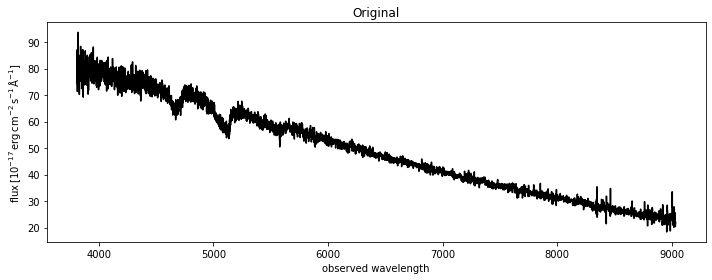

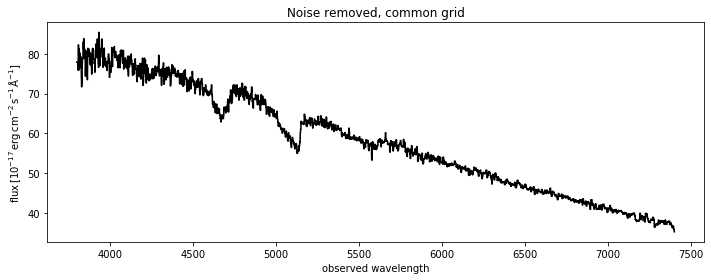

In [33]:
plt.figure(figsize = (15,7))
idx = numpy.random.choice(specs.shape[0])
plt.rcParams['figure.figsize'] = 10, 4
plt.figure()
plt.title('Original')
plt.step(waves[idx], specs[idx], "k")
plt.xlabel("observed wavelength")
plt.ylabel("$\\mathrm{flux\\,[10^{-17}\\, erg \\, cm^{-2} \\, s^{-1} \\, \\AA^{-1}] }$")
plt.tight_layout()

plt.figure()
plt.title('Noise removed, common grid')
plt.step(common_wave, specs_final[idx], "k")
plt.xlabel("observed wavelength")
plt.ylabel("$\\mathrm{flux\\,[10^{-17}\\, erg \\, cm^{-2} \\, s^{-1} \\, \\AA^{-1}] }$")
plt.tight_layout()

In [34]:
import umap
fit = umap.UMAP()

In [35]:
em = fit.fit_transform(specs_final)
x = em[:,0]
y = em[:,1]

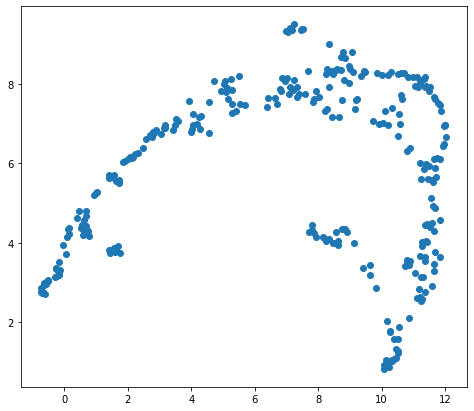

In [36]:
plt.figure(figsize = (8,7))
plt.scatter(x, y)
plt.show()